In [1]:
# from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
# from sklearn.model_selection import train_test_split
import pandas as pd
import os, re, math, platform
from tqdm import tqdm
from collections import Counter
import numpy as np

## 提特征

In [2]:
# Miscellaneous
_AALetter = ['A', 'C', 'D', 'E', 'F', 'G', 'H',
             'I', 'K', 'L', 'M', 'N', 'P', 'Q',
             'R', 'S', 'T', 'V', 'W', 'Y']


"""
n_gram statistics
"""

_AALetter = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 
            'I', 'K', 'L', 'M', 'N', 'P', 'Q', 
            'R', 'S', 'T', 'V', 'W', 'Y']

def get_aan_corpus(n=2):
    '''
    Get AA corpus of n_gram (e.g. Di, Tri, etc.)
    Output: AA n_gram corpus ((e.g. Di:400, Tri:3000, etc.))
    '''
    n_corpus = []
    if n <= 2:
        for i in _AALetter:
            for j in _AALetter:
               n_corpus.append("{}{}".format(i, j))
        return n_corpus
    for i in get_aan_corpus(n - 1):
        for j in _AALetter:
            n_corpus.append("{}{}".format(i, j))
    return n_corpus


def get_ngram_counts(seq, n=2):
    '''
    Get n_gram statistics
    Input: peptide sequence and n
    Ouput: n_gram statistic (dictionary) {A.A Corp: Counts}
    '''
    # Get the name of ngram feature
    if n == 2:
        prefix = 'DPC'
    elif n == 3:
        prefix = 'TPC'
    else:
        prefix = '{}gram'.format(n)

    ngrams = [seq[i: i + n] for i in range(len(seq) - n + 1)]
    n_corpus = get_aan_corpus(n)
    ngram_stat = {}
    for aa_ng in n_corpus:
        ngram_stat['{}|{}'.format(prefix, aa_ng)] = ngrams.count(aa_ng) / len(ngrams) * 100
    return ngram_stat


def minSequenceLength(fastas):
    minLen = 10000
    for i in fastas:
        if minLen > len(i[1]):
            minLen = len(i[1])
    return minLen


def minSequenceLengthWithNormalAA(fastas):
    minLen = 10000
    for i in fastas:
        if minLen > len(re.sub('-', '', i[1])):
            minLen = len(re.sub('-', '', i[1]))
    return minLen


"""
    input.fasta:      the input protein sequence file in fasta format.
    k_space:          the gap of two amino acids, integer, defaule: 5
    output:           the encoding file, default: 'encodings.tsv'
"""


def generateGroupPairs(groupKey):
    gPair = {}
    for key1 in groupKey:
        for key2 in groupKey:
            gPair['CKSAAGP|'+key1+'.'+key2] = 0
    return gPair


def cksaagp(fastas, gap = 5, **kw):
    if gap < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    if minSequenceLength(fastas) < gap+2:
        print('Error: all the sequence length should be greater than the (gap value) + 2 = ' + str(gap+2) + '\n\n')
        return 0

    group = {'aliphatic': 'GAVLMI',
             'aromatic': 'FYW',
             'postivecharge': 'KRH',
             'negativecharge': 'DE',
             'uncharge': 'STCPNQ'}

    AA = 'ARNDCQEGHILKMFPSTWYV'

    groupKey = group.keys()

    index = {}
    for key in groupKey:
        for aa in group[key]:
            index[aa] = key

    gPairIndex = []
    for key1 in groupKey:
        for key2 in groupKey:
            gPairIndex.append('CKSAAGP|'+key1+'.'+key2)

    encodings = []
    header = ['#']
    for g in range(gap + 1):
        for p in gPairIndex:
            header.append(p+'.gap'+str(g))
    encodings.append(header)

    for i in fastas:
        name, sequence = i[0], re.sub('-', '', i[1])
        code = [name]
        for g in range(gap + 1):
            gPair = generateGroupPairs(groupKey)
            sum = 0
            for p1 in range(len(sequence)):
                p2 = p1 + g + 1
                if p2 < len(sequence) and sequence[p1] in AA and sequence[p2] in AA:
                    gPair['CKSAAGP|'+index[sequence[p1]]+'.'+index[sequence[p2]]] = gPair['CKSAAGP|'+index[sequence[p1]]+'.'+index[sequence[p2]]] + 1
                    sum = sum + 1

            if sum == 0:
                for gp in gPairIndex:
                    code.append(0)
            else:
                for gp in gPairIndex:
                    code.append(gPair[gp] / sum)

        encodings.append(code)

    return encodings


"""
    input.fasta:      the input protein sequence file in fasta format.
    lambda:           the lambda value, integer, defaule: 30
    output:           the encoding file, default: 'encodings.tsv'
"""

def Rvalue(aa1, aa2, AADict, Matrix):
    return sum([(Matrix[i][AADict[aa1]] - Matrix[i][AADict[aa2]]) ** 2 for i in range(len(Matrix))]) / len(Matrix)


def paac(fastas, lambdaValue=30, w=0.05, **kw):
    if minSequenceLengthWithNormalAA(fastas) < lambdaValue + 1:
        print('Error: all the sequence length should be larger than the lambdaValue+1: ' + str(lambdaValue + 1) + '\n\n')
        return 0

    # dataFile = re.sub('codes$', '', os.path.split(os.path.realpath('__file__'))[0]) + r'\data\PAAC.txt' if platform.system() == 'Windows' else re.sub('codes$', '', os.path.split(os.path.realpath('__file__'))[0]) + '/data/PAAC.txt'
    dataFile = '../data/PAAC.txt'
    with open(dataFile) as f:
        records = f.readlines()
    AA = ''.join(records[0].rstrip().split()[1:])
    AADict = {}
    for i in range(len(AA)):
        AADict[AA[i]] = i
    AAProperty = []
    AAPropertyNames = []
    for i in range(1, len(records)):
        array = records[i].rstrip().split() if records[i].rstrip() != '' else None
        AAProperty.append([float(j) for j in array[1:]])
        AAPropertyNames.append(array[0])

    AAProperty1 = []
    for i in AAProperty:
        meanI = sum(i) / 20
        fenmu = math.sqrt(sum([(j-meanI)**2 for j in i])/20)
        AAProperty1.append([(j-meanI)/fenmu for j in i])

    encodings = []
    header = ['#']
    for aa in AA:
        header.append('PAAC|' + aa)
    for n in range(1, lambdaValue + 1):
        header.append('PAAC|lambda' + str(n))
    encodings.append(header)

    for i in fastas:
        name, sequence = i[0], re.sub('-', '', i[1])
        code = [name]
        theta = []
        for n in range(1, lambdaValue + 1):
            theta.append(
                sum([Rvalue(sequence[j], sequence[j + n], AADict, AAProperty1) for j in range(len(sequence) - n)]) / (
                len(sequence) - n))
        myDict = {}
        for aa in AA:
            myDict[aa] = sequence.count(aa)
        code = code + [myDict[aa] / (1 + w * sum(theta)) for aa in AA]
        code = code + [(w * j) / (1 + w * sum(theta)) for j in theta]
        encodings.append(code)
    return encodings


def GAAC(fastas, **kw):
	group = {
		'alphatic': 'GAVLMI',
		'aromatic': 'FYW',
		'postivecharge': 'KRH',
		'negativecharge': 'DE',
		'uncharge': 'STCPNQ'
	}

	groupKey = group.keys()

	encodings = []
	header = ['#']
	for key in groupKey:
		header.append("GAAC|"+key)
	encodings.append(header)

	for i in fastas:
		name, sequence = i[0], re.sub('-', '', i[1])
		code = [name]
		count = Counter(sequence)
		myDict = {}
		for key in groupKey:
			for aa in group[key]:
				myDict[key] = myDict.get(key, 0) + count[aa]

		for key in groupKey:
			code.append(myDict[key]/len(sequence))
		encodings.append(code)

	return encodings


def GDPC(fastas, **kw):
	group = {
		'alphaticr': 'GAVLMI',
		'aromatic': 'FYW',
		'postivecharger': 'KRH',
		'negativecharger': 'DE',
		'uncharger': 'STCPNQ'
	}

	groupKey = group.keys()
	baseNum = len(groupKey)
	dipeptide = [g1+'.'+g2 for g1 in groupKey for g2 in groupKey]

	index = {}
	for key in groupKey:
		for aa in group[key]:
			index[aa] = key

	encodings = []
	header = ['#'] + ['GDPC|'+dipname for dipname in dipeptide]
	encodings.append(header)

	for i in fastas:
		name, sequence = i[0], re.sub('-', '', i[1])

		code = [name]
		myDict = {}
		for t in dipeptide:
			myDict[t] = 0

		sum = 0
		for j in range(len(sequence) - 2 + 1):
			myDict[index[sequence[j]]+'.'+index[sequence[j+1]]] = myDict[index[sequence[j]]+'.'+index[sequence[j+1]]] + 1
			sum = sum +1

		if sum == 0:
			for t in dipeptide:
				code.append(0)
		else:
			for t in dipeptide:
				code.append(myDict[t]/sum)
		encodings.append(code)

	return encodings


def GTPC(fastas, **kw):
	group = {
		'alphaticr': 'GAVLMI',
		'aromatic': 'FYW',
		'postivecharger': 'KRH',
		'negativecharger': 'DE',
		'uncharger': 'STCPNQ'
	}

	groupKey = group.keys()
	baseNum = len(groupKey)
	triple = [g1+'.'+g2+'.'+g3 for g1 in groupKey for g2 in groupKey for g3 in groupKey]

	index = {}
	for key in groupKey:
		for aa in group[key]:
			index[aa] = key

	encodings = []
	header = ['#'] + ['GTPC|'+tname for tname in triple]
	encodings.append(header)

	for i in fastas:
		name, sequence = i[0], re.sub('-', '', i[1])

		code = [name]
		myDict = {}
		for t in triple:
			myDict[t] = 0

		sum = 0
		for j in range(len(sequence) - 3 + 1):
			myDict[index[sequence[j]]+'.'+index[sequence[j+1]]+'.'+index[sequence[j+2]]] = myDict[index[sequence[j]]+'.'+index[sequence[j+1]]+'.'+index[sequence[j+2]]] + 1
			sum = sum +1

		if sum == 0:
			for t in triple:
				code.append(0)
		else:
			for t in triple:
				code.append(myDict[t]/sum)
		encodings.append(code)

	return encodings

'''
Insert Iso_electric Point and net_charge(neutral) feature to the sequence data_frame
Input: sequence data_frame {IDx: Seq_x, ...}
Output: data_frame of Peptide Seq {IDx: Seq_x, ..., iep, net_charge}
'''


def insert_phycs(seq_df):
    global feature_list
    seq_df = seq_df.copy()
    #  Function for compute Isoelectric Point or net_charge of peptide
    def get_ieq_nc(seq, is_iep=True):
        protparam = PA(seq)
        return protparam.isoelectric_point() if is_iep else protparam.charge_at_pH(7.0)

    # Calculating IsoElectricPoints and NeutralCharge
    data_size = seq_df.size
    seq_df['PHYC|IEP'] = list(map(get_ieq_nc, seq_df['Sequence'], [True] * data_size))  # IsoElectricPoints
    seq_df['PHYC|Net Charge'] = list(map(get_ieq_nc, seq_df['Sequence'], [False] * data_size))  # Charge(Neutral)

    # Calculating hydrophobic moment (My assume all peptides are alpha-helix)
    descrpt = PeptideDescriptor(seq_df['Sequence'].values, 'eisenberg')
    descrpt.calculate_moment(window=1000, angle=100, modality='max')
    seq_df['PHYC|Hydrophobic Moment'] = descrpt.descriptor.reshape(-1)

    # Calculating "Hopp-Woods" hydrophobicity
    descrpt = PeptideDescriptor(seq_df['Sequence'].values, 'hopp-woods')
    descrpt.calculate_global()
    seq_df['PHYC|Hydrophobicity'] = descrpt.descriptor.reshape(-1)

    # Calculating Energy of Transmembrane Propensity
    descrpt = PeptideDescriptor(seq_df['Sequence'].values, 'tm_tend')
    descrpt.calculate_global()
    seq_df['PHYC|Transmembrane Propensity'] = descrpt.descriptor.reshape(-1)

    # Calculating Aromaticity
    descrpt = GlobalDescriptor(seq_df['Sequence'].values)
    descrpt.aromaticity()
    seq_df['PHYC|Aromacity'] = descrpt.descriptor.reshape(-1)

    # Calculating Levitt_alpha_helical Propensity
    descrpt = PeptideDescriptor(seq_df['Sequence'].values, 'levitt_alpha')
    descrpt.calculate_global()
    seq_df['PHYC|Alpha Helical Propensity'] = descrpt.descriptor.reshape(-1)

    # Calculating Aliphatic Index
    descrpt = GlobalDescriptor(seq_df['Sequence'].values)
    descrpt.aliphatic_index()
    seq_df['PHYC|Aliphatic Index'] = descrpt.descriptor.reshape(-1)

    # Calculating Boman Index
    descrpt = GlobalDescriptor(seq_df['Sequence'].values)
    descrpt.boman_index()
    seq_df['PHYC|Boman Index'] = descrpt.descriptor.reshape(-1)

    feature_list.append('PHYCS')

    return seq_df


'''
Insert Amino acid composition to the sequence data_frame
Input: sequence data_frame {IDx: Seq_x}
Output: data_frame of Peptide Seq {IDx: Seq_x, ..., AAC_Ax ... AAC_Yx}
'''


def insert_aac(seq_df):
    global feature_list # changed
    seq_df = seq_df.copy()
    # Compute AAC for peptide in specific A.A
    def get_aac(seq, aa):
        return seq.count(aa) / len(seq) * 100

    # processing data_frame
    data_size = seq_df.size
    for ll in _AALetter:
        seq_df['AAC_{}'.format(ll)] = list(map(get_aac, seq_df['Sequence'], [ll] * data_size))
    feature_list.append('AAC')
    return seq_df


'''
Insert n_grams Descriptor to the sequence data_frame
Input: sequence data_frame {IDx: Seq_x, ...}
Output: data_frame of Peptide Seq {IDx: Seq_x, ..., ngram_(1), .., ngram(20 ** n)}
'''


def insert_ngrams(seq_df, n=2):
    global feature_list # changed
    seq_df = seq_df.copy()
    data_size = seq_df.size

    ngrams_df = list(map(get_ngram_counts, seq_df['Sequence'], [n] * data_size))
    ngrams_df = pd.DataFrame(ngrams_df)  # Convert ngrams features to pd.DataFrame
    seq_df = pd.concat([seq_df, ngrams_df], axis=1)
    feature_list.append('DPC')
    return seq_df


"""
Insert CKSAAGP Descriptor to the sequence data_frame
(Composition of k-spaced amino acid pairs)
Input: sequence data_frame {IDx: Seq_x, ...}
Output: data_frame of Peptide Seq {IDx: Seq_x, ..., CKSAAGP(0), ..., CKSAAGP(m)}
"""


def insert_cksaagp(seq_df, gap=2):
    global feature_list # changed
    seq_df.copy()
    fastas = [[idx, seq] for idx, seq in zip(seq_df['Id'], seq_df['Sequence'])]
    encoding = cksaagp(fastas, gap=gap)
    encoding = pd.DataFrame(encoding[1:], columns=encoding[0])
    seq_df = pd.concat([seq_df, encoding.iloc[:, 1:]], axis=1)
    feature_list.append('CKSAAGP')
    return seq_df


"""
Insert PAAC Descriptor to the sequence data_frame
(Pseudo Amino Acid Composition)
Input: sequence data_frame {IDx: Seq_x, ...}
Output: data_frame of Peptide Seq {IDx: Seq_x, ..., CKSAAGP(0), ..., CKSAAGP(m)}
"""


def insert_paac(seq_df, lamb=3, w=0.1):
    global feature_list # changed
    seq_df = seq_df.copy()
    fastas = [[idx, seq] for idx, seq in zip(seq_df['Id'], seq_df['Sequence'])]
    encoding = paac(fastas, lambdaValue=lamb, w=w)
    encoding = pd.DataFrame(encoding[1:], columns=encoding[0])
    seq_df = pd.concat([seq_df, encoding.iloc[:, 1:]], axis=1)
    feature_list.append('PAAC')
    return seq_df


"""
Insert Grouped n-gram Descriptor to the sequence data_frame
(Pseudo Amino Acid Composition)
Input: sequence data_frame {IDx: Seq_x, ...}
Output: data_frame of Peptide Seq {IDx: Seq_x, ..., CKSAAGP(0), ..., CKSAAGP(m)}
"""


def insert_gngram(seq_df, n=1): # 
    seq_df = seq_df.copy()
    fastas = [[idx, seq] for idx, seq in zip(seq_df['Id'], seq_df['Sequence'])]
    # encoding = paac(fastas, lambdaValue=lamb, w=w)
    if n == 1:
        encoding = GAAC(fastas)
    elif n == 2:
        encoding = GDPC(fastas)
    elif n == 3:
        encoding = GTPC(fastas)
    else:
        raise Warning("Invalid n-grams, no features added")
    encoding = pd.DataFrame(encoding[1:], columns=encoding[0])
    seq_df = pd.concat([seq_df, encoding.iloc[:, 1:]], axis=1)
    return seq_df


In [3]:
# file IO functions
import pandas as pd
from Bio import Seq, SeqIO


def write_fasta(df, file_path, abbr_columns=None):
    """
    Save dataframe to a .fasta file, the df should contain at least columns named "Id" and "Sequence"
    
    df: dataframe for saving .fasta
    file_path: path(string) for saving the fasta file
    abbr_columns: string columns for adding abbreviations. Multiple abbr are splited by '|'.
    """
    Seqrecords = [SeqIO.SeqRecord(id=row['Id'], 
                              seq=Seq.Seq(row['Sequence']), 
                              description='|'.join(row[abbr_columns] if abbr_columns is not None else "")) \
             for idn, row in df.iterrows()]
    with open(file_path, 'w+') as fhandle:
        SeqIO.write(Seqrecords, fhandle, "fasta-2line")
        print("Saved {:d} sequences.".format(len(Seqrecords)))


def read_fasta(fname):
    '''
    Read fasta file to dictionary
    Input: path name of fasta
    Output: dataframe of Peptide Seq {ID1: Seq1, ID2: Seq2,...}
    '''
    with open(fname, "rU") as f:
        seq_dict = [(record.id, record.seq._data) for record in SeqIO.parse(f, "fasta")]
    seq_df = pd.DataFrame(data=seq_dict, columns=["Id", "Sequence"])
    return seq_df


In [4]:
def construct_features(seq_df, paaclamb=6, paacw=0.5):
    """
    Construct Features for the AVPIden. We first investigated physiochemical feautres, AAC features, DiC features, 
    CKSAAGP features, PAAC features, and PHYC features.
    Parameters are pre-set according to the sequence identities.
    """
    seq_df = insert_aac(seq_df)
    # seq_df = insert_ngrams(seq_df, n=2)
    # seq_df = insert_cksaagp(seq_df, gap=3) # As the maximum motif length = 5.
    # seq_df = insert_paac(seq_df, lamb=paaclamb, w=paacw)
    # seq_df = insert_phycs(seq_df)

    return seq_df

### 筛选长度并分组 创建特征

In [15]:
feature_list = list()

df = read_fasta('sequence.fasta')
features = construct_features(df)
print(features.shape)

features['len'] = [len(a) for a in features['Sequence']]
features = features[features.len <= 50]
features = features[features.len >= 10]

(4166, 22)


<ipython-input-13-63b35be0f9b8>:29: DeprecationWarning: 'U' mode is deprecated
  with open(fname, "rU") as f:


In [16]:
features.shape

(4041, 23)

In [17]:
# grouping
features['group'] = pd.cut(features['len'], [9, 20, 26, 50], labels=['10-20', '21-26','27-50'])
features

,Id,Sequence,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,...,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,len,group
0,sequence0,LKKLLKWLLKLLK,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.692308,0.000000,13,10-20
1,sequence1,GLPRKILAAIAKKKGKCKGPLKLVAKC,14.814815,7.407407,0.000000,0.0,0.000000,11.111111,0.000000,7.407407,...,7.407407,0.000000,3.703704,0.000000,0.000000,3.703704,0.000000,0.000000,27,27-50
2,sequence2,LKWGAILKHIIK,8.333333,0.000000,0.000000,0.0,0.000000,8.333333,8.333333,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.333333,0.000000,12,10-20
3,sequence3,YIPQPRPPHPRL,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8.333333,8.333333,...,41.666667,8.333333,16.666667,0.000000,0.000000,0.000000,0.000000,8.333333,12,10-20
4,sequence4,SIRDKIKTIAIDLAKSAGTGVLKTLICKLNKSC,9.090909,6.060606,6.060606,0.0,0.000000,6.060606,0.000000,15.151515,...,0.000000,0.000000,3.030303,9.090909,9.090909,3.030303,0.000000,0.000000,33,27-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,sequence4161,FIGPVLKMATSILPTAICKGFKKC,8.333333,8.333333,0.000000,0.0,8.333333,8.333333,0.000000,12.500000,...,8.333333,0.000000,0.000000,4.166667,8.333333,4.166667,0.000000,0.000000,24,21-26
4162,sequence4162,FIGPVLKIAAGILPTAICKIFKKC,12.500000,8.333333,0.000000,0.0,8.333333,8.333333,0.000000,20.833333,...,8.333333,0.000000,0.000000,0.000000,4.166667,4.166667,0.000000,0.000000,24,21-26
4163,sequence4163,ALWKNMLKGIGKLAGQAALGAVKTLVGA,21.428571,0.000000,0.000000,0.0,0.000000,17.857143,0.000000,3.571429,...,0.000000,3.571429,0.000000,0.000000,3.571429,7.142857,3.571429,0.000000,28,27-50
4164,sequence4164,ACQFWSCNSSCISRGYRQGYCWGIQYKYCQCQ,3.125000,18.750000,0.000000,0.0,3.125000,9.375000,0.000000,6.250000,...,0.000000,15.625000,6.250000,12.500000,0.000000,0.000000,6.250000,12.500000,32,27-50


In [18]:
features['group'].unique()

['10-20', '27-50', '21-26']
Categories (3, object): ['10-20' < '21-26' < '27-50']

In [38]:
features.group.value_counts()

10-20    2261
21-26     906
27-50     874
Name: group, dtype: int64

In [19]:
features

,Id,Sequence,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,...,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,len,group
0,sequence0,LKKLLKWLLKLLK,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.692308,0.000000,13,10-20
1,sequence1,GLPRKILAAIAKKKGKCKGPLKLVAKC,14.814815,7.407407,0.000000,0.0,0.000000,11.111111,0.000000,7.407407,...,7.407407,0.000000,3.703704,0.000000,0.000000,3.703704,0.000000,0.000000,27,27-50
2,sequence2,LKWGAILKHIIK,8.333333,0.000000,0.000000,0.0,0.000000,8.333333,8.333333,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.333333,0.000000,12,10-20
3,sequence3,YIPQPRPPHPRL,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8.333333,8.333333,...,41.666667,8.333333,16.666667,0.000000,0.000000,0.000000,0.000000,8.333333,12,10-20
4,sequence4,SIRDKIKTIAIDLAKSAGTGVLKTLICKLNKSC,9.090909,6.060606,6.060606,0.0,0.000000,6.060606,0.000000,15.151515,...,0.000000,0.000000,3.030303,9.090909,9.090909,3.030303,0.000000,0.000000,33,27-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,sequence4161,FIGPVLKMATSILPTAICKGFKKC,8.333333,8.333333,0.000000,0.0,8.333333,8.333333,0.000000,12.500000,...,8.333333,0.000000,0.000000,4.166667,8.333333,4.166667,0.000000,0.000000,24,21-26
4162,sequence4162,FIGPVLKIAAGILPTAICKIFKKC,12.500000,8.333333,0.000000,0.0,8.333333,8.333333,0.000000,20.833333,...,8.333333,0.000000,0.000000,0.000000,4.166667,4.166667,0.000000,0.000000,24,21-26
4163,sequence4163,ALWKNMLKGIGKLAGQAALGAVKTLVGA,21.428571,0.000000,0.000000,0.0,0.000000,17.857143,0.000000,3.571429,...,0.000000,3.571429,0.000000,0.000000,3.571429,7.142857,3.571429,0.000000,28,27-50
4164,sequence4164,ACQFWSCNSSCISRGYRQGYCWGIQYKYCQCQ,3.125000,18.750000,0.000000,0.0,3.125000,9.375000,0.000000,6.250000,...,0.000000,15.625000,6.250000,12.500000,0.000000,0.000000,6.250000,12.500000,32,27-50


In [20]:
# write files
groups = ['10-20', '21-26','27-50']
for group in groups:
    output = features[features['group'] == group].drop(['Id', 'len', 'group'], axis=1)
    output.to_csv(f'{group}.csv', index=False)

In [21]:
# normalization (of the whole dataframe)
columns = features.iloc[:, 2:-2].columns
n_features = features.filter(['Id','Sequence','len','group'])

for i in columns:
    n_features[i] = (features.loc[:,i]- np.mean(features.loc[:,i])) / np.std(features.loc[:,i])
n_features

,Id,Sequence,len,group,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,...,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,sequence0,LKKLLKWLLKLLK,13,10-20,-0.909927,-0.489354,-0.471387,-0.44385,-0.839724,-1.168580,...,-0.440145,-0.640232,-0.533614,-0.505743,-0.724217,-0.844889,-0.636095,-0.895883,0.602378,-0.420205
1,sequence1,GLPRKILAAIAKKKGKCKGPLKLVAKC,27,27-50,0.812797,0.805166,-0.471387,-0.44385,-0.839724,0.357454,...,-0.440145,-0.640232,0.427536,-0.505743,-0.403834,-0.844889,-0.636095,-0.395334,-0.514499,-0.420205
2,sequence2,LKWGAILKHIIK,12,10-20,0.059105,-0.489354,-0.471387,-0.44385,-0.839724,-0.024055,...,-0.440145,-0.640232,-0.533614,-0.505743,-0.724217,-0.844889,-0.636095,-0.895883,0.695452,-0.420205
3,sequence3,YIPQPRPPHPRL,12,10-20,-0.909927,-0.489354,-0.471387,-0.44385,-0.839724,-1.168580,...,-0.440145,-0.640232,4.872853,2.065112,0.717505,-0.844889,-0.636095,-0.895883,-0.514499,2.152283
4,sequence4,SIRDKIKTIAIDLAKSAGTGVLKTLICKLNKSC,33,27-50,0.147199,0.569798,1.909406,-0.44385,-0.839724,-0.336198,...,-0.440145,0.232307,-0.533614,-0.505743,-0.462086,1.009329,1.670381,-0.486343,-0.514499,-0.420205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,sequence4161,FIGPVLKMATSILPTAICKGFKKC,24,21-26,0.059105,0.966981,-0.471387,-0.44385,0.480809,-0.024055,...,1.165598,-0.640232,0.547679,-0.505743,-0.724217,0.004961,1.478175,-0.332766,-0.514499,-0.420205
4162,sequence4162,FIGPVLKIAAGILPTAICKIFKKC,24,21-26,0.543621,0.966981,-0.471387,-0.44385,0.480809,-0.024055,...,-0.440145,-0.640232,0.547679,-0.505743,-0.724217,-0.844889,0.421040,-0.332766,-0.514499,-0.420205
4163,sequence4163,ALWKNMLKGIGKLAGQAALGAVKTLVGA,28,27-50,1.581870,-0.489354,-0.471387,-0.44385,-0.839724,1.283974,...,0.936206,0.388118,-0.533614,0.596052,-0.724217,-0.844889,0.270021,0.069461,0.004051,-0.420205
4164,sequence4164,ACQFWSCNSSCISRGYRQGYCWGIQYKYCQCQ,32,27-50,-0.546540,2.787399,-0.471387,-0.44385,-0.344524,0.119011,...,-0.440145,0.259574,-0.533614,4.314610,-0.183571,1.704662,-0.636095,-0.895883,0.392964,3.438527


In [22]:
features10 = n_features[n_features['group'] == '10-20']
features15 = n_features[n_features['group'] == 'B']
features20 = n_features[n_features['group'] == 'C']
features25 = n_features[n_features['group'] == 'D']
features30 = n_features[n_features['group'] == 'E']
features35 = n_features[n_features['group'] == 'F']
features40 = n_features[n_features['group'] == 'G']

In [23]:
features10

,Id,Sequence,len,group,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,...,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,sequence0,LKKLLKWLLKLLK,13,10-20,-0.909927,-0.489354,-0.471387,-0.44385,-0.839724,-1.168580,...,-0.440145,-0.640232,-0.533614,-0.505743,-0.724217,-0.844889,-0.636095,-0.895883,0.602378,-0.420205
2,sequence2,LKWGAILKHIIK,12,10-20,0.059105,-0.489354,-0.471387,-0.44385,-0.839724,-0.024055,...,-0.440145,-0.640232,-0.533614,-0.505743,-0.724217,-0.844889,-0.636095,-0.895883,0.695452,-0.420205
3,sequence3,YIPQPRPPHPRL,12,10-20,-0.909927,-0.489354,-0.471387,-0.44385,-0.839724,-1.168580,...,-0.440145,-0.640232,4.872853,2.065112,0.717505,-0.844889,-0.636095,-0.895883,-0.514499,2.152283
6,sequence6,DVIKKVASVIGGL,13,10-20,-0.015436,-0.489354,2.550389,-0.44385,-0.839724,0.944390,...,-0.440145,-0.640232,-0.533614,-0.505743,-0.724217,0.724065,-0.636095,2.222920,-0.514499,-0.420205
7,sequence7,ALVYAGIKKTAFLKVQKCDG,20,10-20,0.834331,0.384447,1.492767,-0.44385,-0.047404,0.204850,...,-0.440145,-0.640232,-0.533614,1.036770,-0.724217,-0.844889,0.632467,0.455598,-0.514499,1.123288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,sequence4154,GLFDKWAWWRWRR,13,10-20,-0.015436,-0.489354,2.550389,-0.44385,0.379230,-0.112095,...,-0.440145,-0.640232,-0.533614,-0.505743,1.272013,-0.844889,-0.636095,-0.895883,3.953010,-0.420205
4157,sequence4157,LRRLRKWLRRLLKLL,15,10-20,-0.909927,-0.489354,-0.471387,-0.44385,-0.839724,-1.168580,...,-0.440145,-0.640232,-0.533614,-0.505743,2.159227,-0.844889,-0.636095,-0.895883,0.453462,-0.420205
4158,sequence4158,RVCSAIPLPICH,12,10-20,0.059105,2.423315,-0.471387,-0.44385,-0.839724,-1.168580,...,-0.440145,-0.640232,1.628973,-0.505743,-0.003356,0.854811,-0.636095,0.230351,-0.514499,-0.420205
4159,sequence4159,KWKLFKKIGPGKFLHSAKKF,20,10-20,-0.328508,-0.489354,-0.471387,-0.44385,1.537236,0.204850,...,-0.440145,-0.640232,0.115162,-0.505743,-0.724217,0.174931,-0.636095,-0.895883,0.211471,-0.420205


### 把df转换为n_dim_array

In [24]:
def process(df):
    '''1. convert dataframe to array
    '''
    df = df.iloc[:, 4:].values
    return df


In [25]:
features10 = process(features10)
features15 = process(features15)
features20 = process(features20)
features25 = process(features25)
features30 = process(features30)
features35 = process(features35)
features40 = process(features40)

In [26]:
features10

array([[-0.90992738, -0.48935403, -0.47138678, ..., -0.89588292,
         0.6023785 , -0.42020541],
       [ 0.05910502, -0.48935403, -0.47138678, ..., -0.89588292,
         0.69545161, -0.42020541],
       [-0.90992738, -0.48935403, -0.47138678, ..., -0.89588292,
        -0.51449878,  2.1522828 ],
       ...,
       [ 0.05910502,  2.42331522, -0.47138678, ...,  0.23035136,
        -0.51449878, -0.42020541],
       [-0.32850794, -0.48935403, -0.47138678, ..., -0.89588292,
         0.21147145, -0.42020541],
       [ 0.38211583, -0.48935403, -0.47138678, ..., -0.14506007,
        -0.51449878, -0.42020541]])

In [27]:
print(features10.shape)
print(features15.shape)
print(features20.shape)
print(features25.shape)
print(features30.shape)
print(features35.shape)
print(features40.shape)

(2261, 20)
(0, 20)
(0, 20)
(0, 20)
(0, 20)
(0, 20)
(0, 20)


In [28]:
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### 创建一大个dataframe

In [29]:
alldata = np.concatenate([features10, features15, features20, features25, features30, features35, features40], axis=0)
np.nan_to_num(alldata, copy=False)

array([[-0.90992738, -0.48935403, -0.47138678, ..., -0.89588292,
         0.6023785 , -0.42020541],
       [ 0.05910502, -0.48935403, -0.47138678, ..., -0.89588292,
         0.69545161, -0.42020541],
       [-0.90992738, -0.48935403, -0.47138678, ..., -0.89588292,
        -0.51449878,  2.1522828 ],
       ...,
       [ 0.05910502,  2.42331522, -0.47138678, ...,  0.23035136,
        -0.51449878, -0.42020541],
       [-0.32850794, -0.48935403, -0.47138678, ..., -0.89588292,
         0.21147145, -0.42020541],
       [ 0.38211583, -0.48935403, -0.47138678, ..., -0.14506007,
        -0.51449878, -0.42020541]])

### 做embedding

In [30]:
reducer = umap.UMAP(random_state=42)
# reducer = PCA(n_components=3)
embedding = reducer.fit_transform(alldata)
# print(reducer.explained_variance_ratio_)
print(embedding.shape)

(2261, 2)


In [31]:
embedding

array([[11.415746 , 13.833113 ],
       [12.507539 ,  5.475468 ],
       [-0.6812327, 10.302627 ],
       ...,
       [ 9.8836   ,  7.2838597],
       [13.041804 , 13.009606 ],
       [12.559015 ,  6.6062126]], dtype=float32)

In [32]:
# l = [1116, 960, 804, 386, 236, 192, 162]
# s = 0
# for i in l:
#     s += i
#     print(s)

In [33]:
embedding.shape

(2261, 2)

### 画embedding图

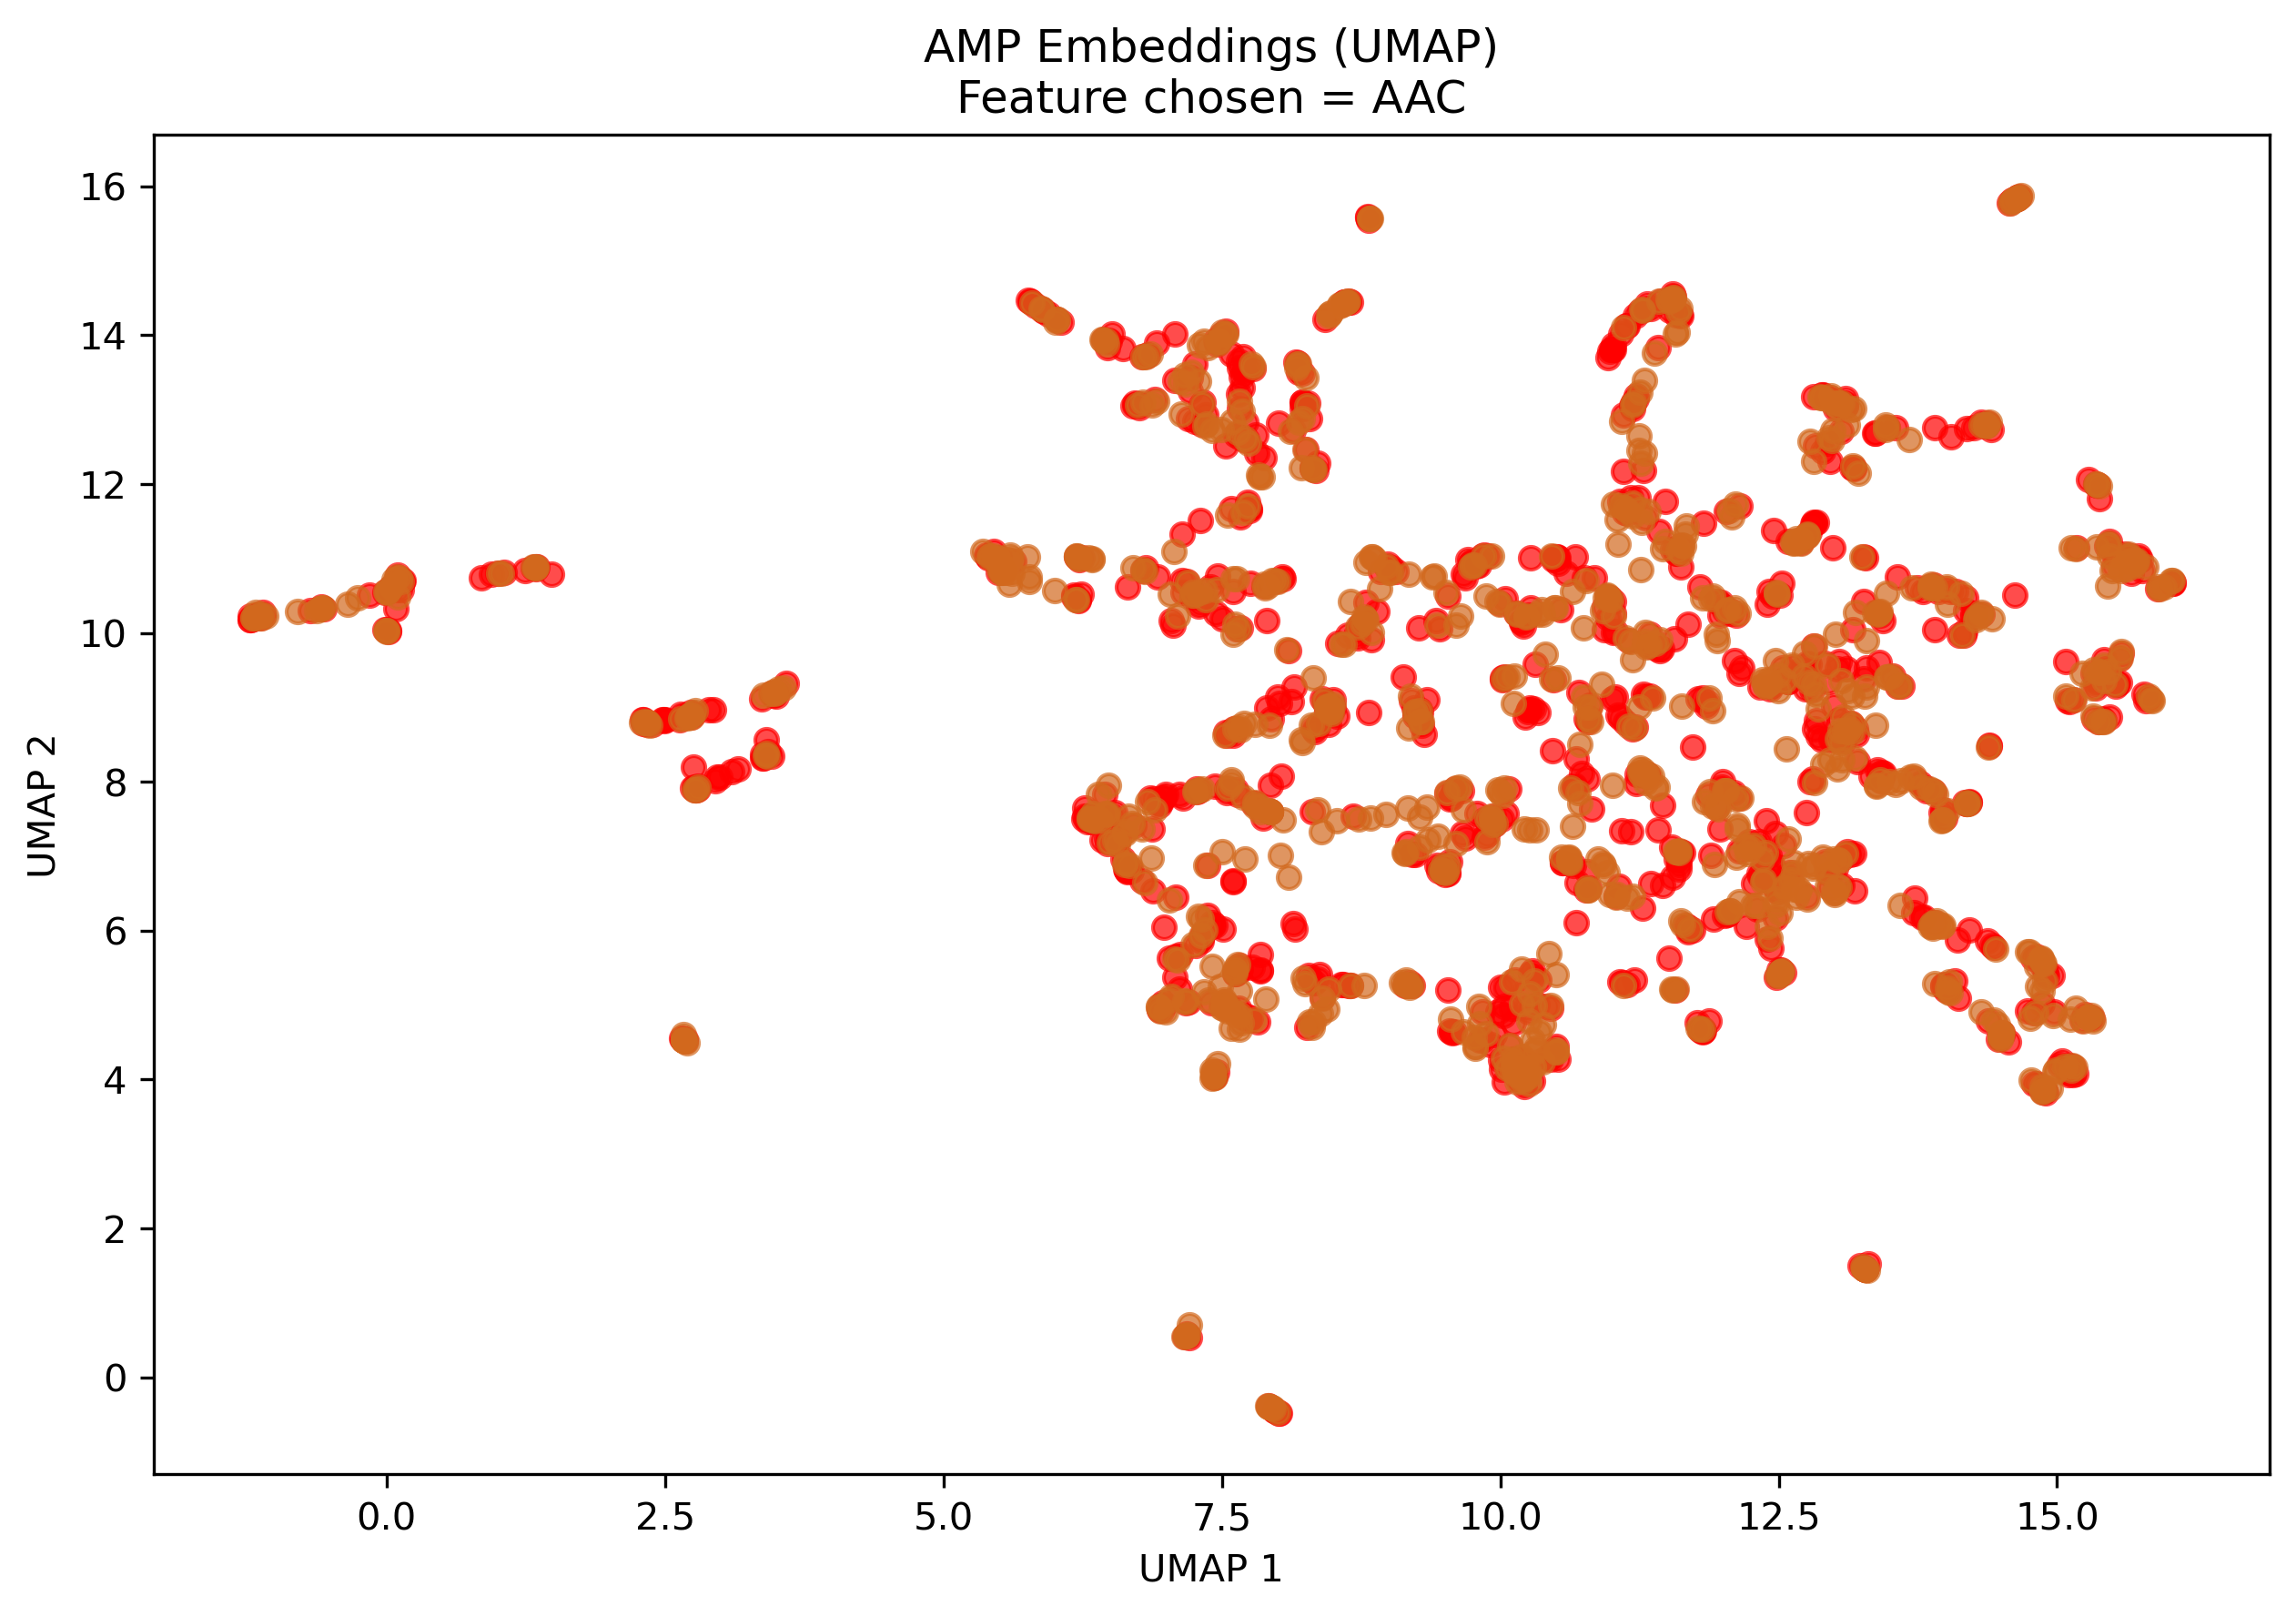

In [34]:
# 1116, 960, 804, 386, 236, 192, 162
# red, chocolate, yellowgreen, turquoise, blue, blueviolet
aa = embedding[0:1116]
bb = embedding[1116: 2076]
cc = embedding[2880:3266]
dd = embedding[3266:3502]
ee = embedding[3502:3694]
ff = embedding[3694:3856]

plt.figure(figsize=(10, 6.5), dpi=300)
plt.scatter(aa[:, 0], aa[:, 1], c='red', alpha=0.7)
plt.scatter(ff[:, 0], ff[:, 1], c='blue', alpha=0.7)
plt.scatter(bb[:, 0], bb[:, 1], c='chocolate', alpha=0.7)
plt.scatter(cc[:, 0], cc[:, 1], c='yellowgreen', alpha=0.7)
plt.scatter(dd[:, 0], dd[:, 1], c='turquoise', alpha=0.7)
plt.scatter(ee[:, 0], ee[:, 1], c='blueviolet', alpha=0.7)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title(f"AMP Embeddings (UMAP)\nFeature chosen = {' '.join(feature_list)}")
plt.show()

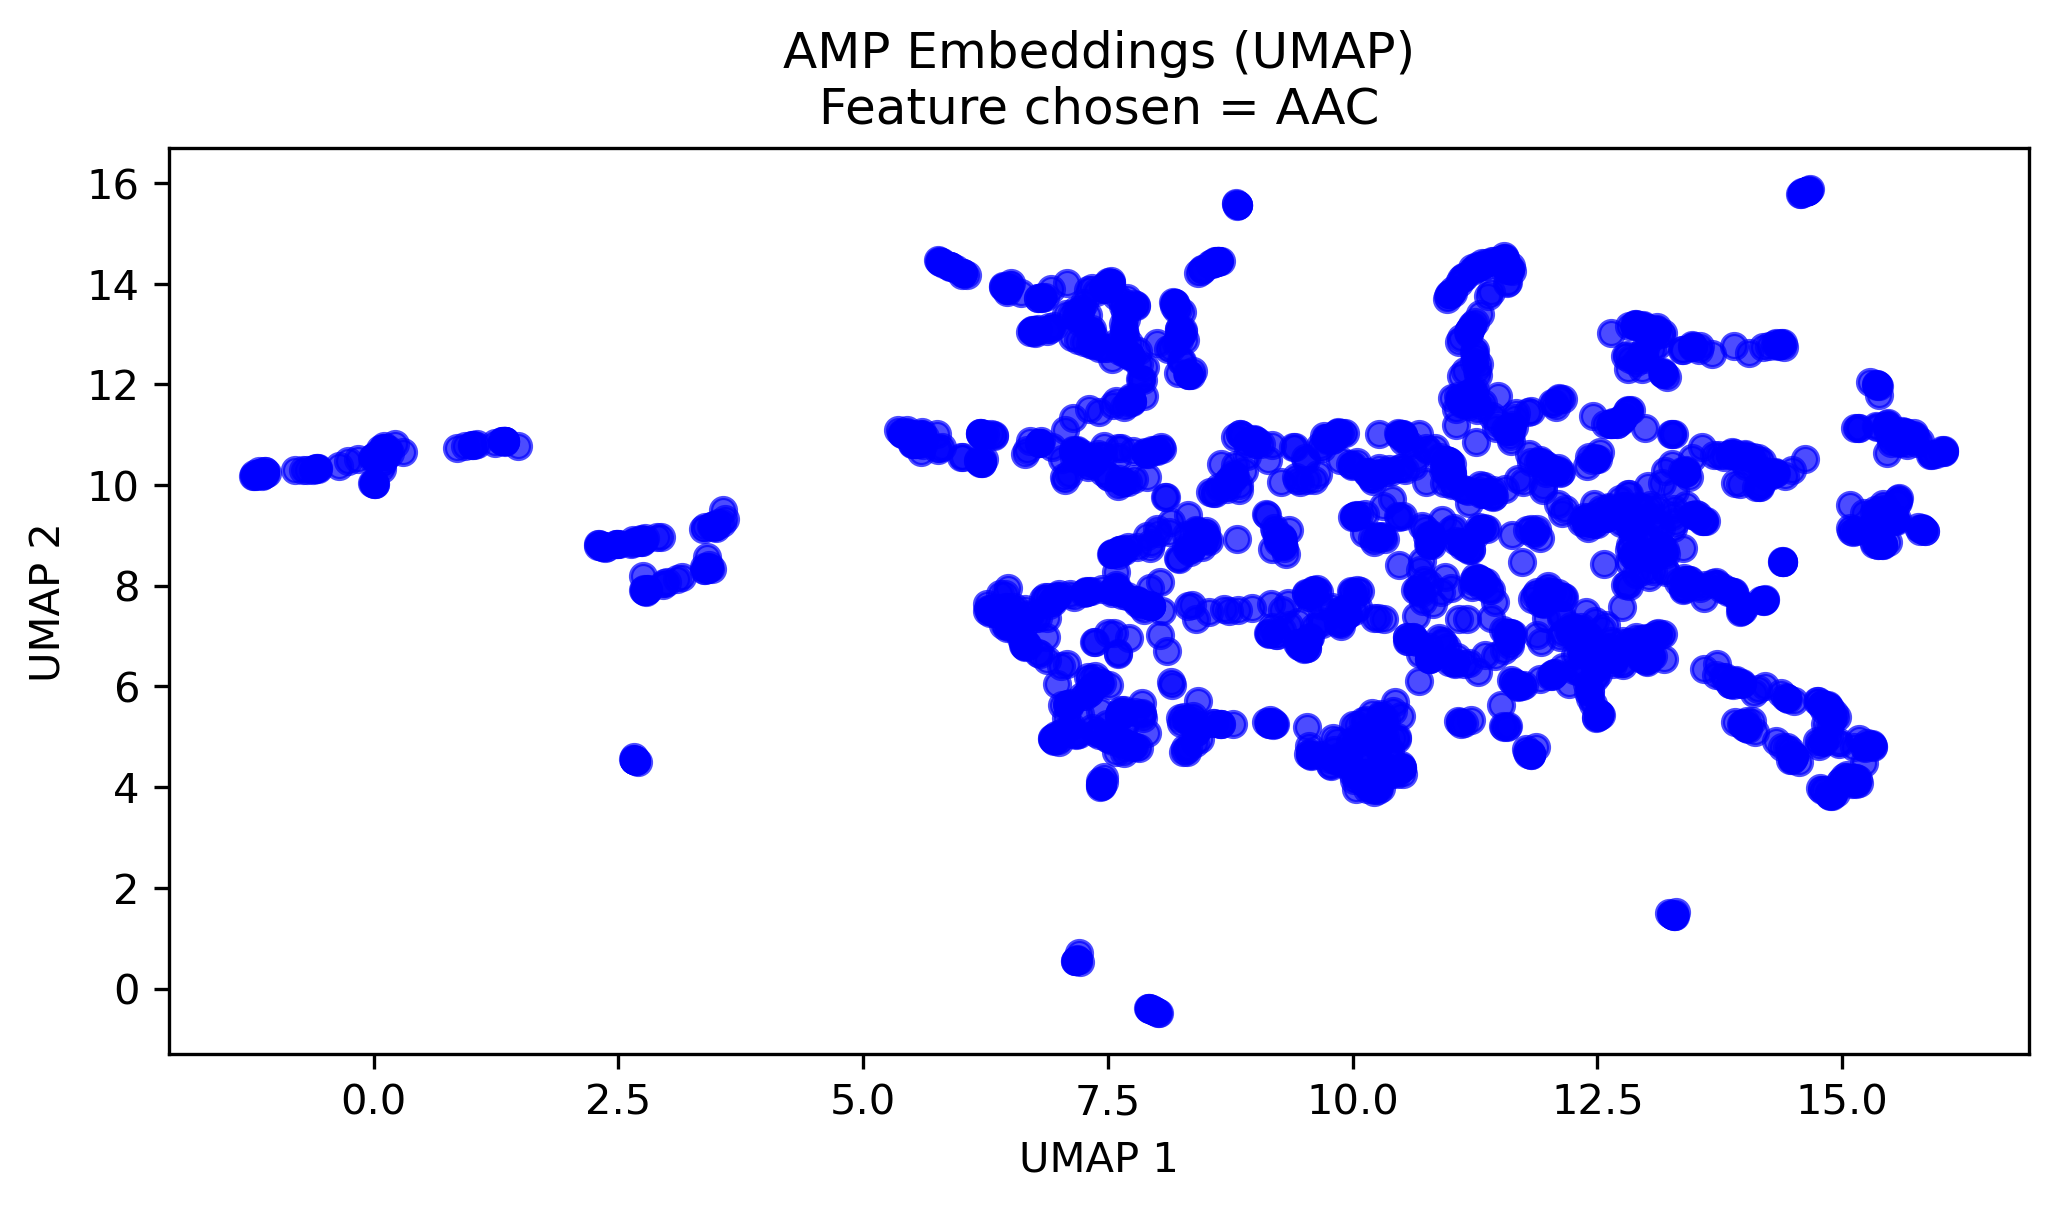

In [35]:
# 1116, 960, 804, 386, 236, 192, 162
# red, chocolate, yellowgreen, turquoise, blue, blueviolet
aa = embedding[0:2880]
bb = embedding[2881: ]
# cc = embedding[2880:3266]
# dd = embedding[3266:3502]
# ee = embedding[3502:3694]
# ff = embedding[3694:3856]

plt.figure(figsize=(8, 4), dpi=300)
# plt.scatter(ff[:, 0], ff[:, 1], c='blue', alpha=0.7)
plt.scatter(aa[:, 0], aa[:, 1], c='blue', alpha=0.7)
plt.scatter(bb[:, 0], bb[:, 1], c='chocolate', alpha=0.7)
# plt.scatter(cc[:, 0], cc[:, 1], c='yellowgreen', alpha=0.7)
# plt.scatter(dd[:, 0], dd[:, 1], c='turquoise', alpha=0.7)
# plt.scatter(ee[:, 0], ee[:, 1], c='blueviolet', alpha=0.7)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title(f"AMP Embeddings (UMAP)\nFeature chosen = {' '.join(feature_list)}")
plt.show()

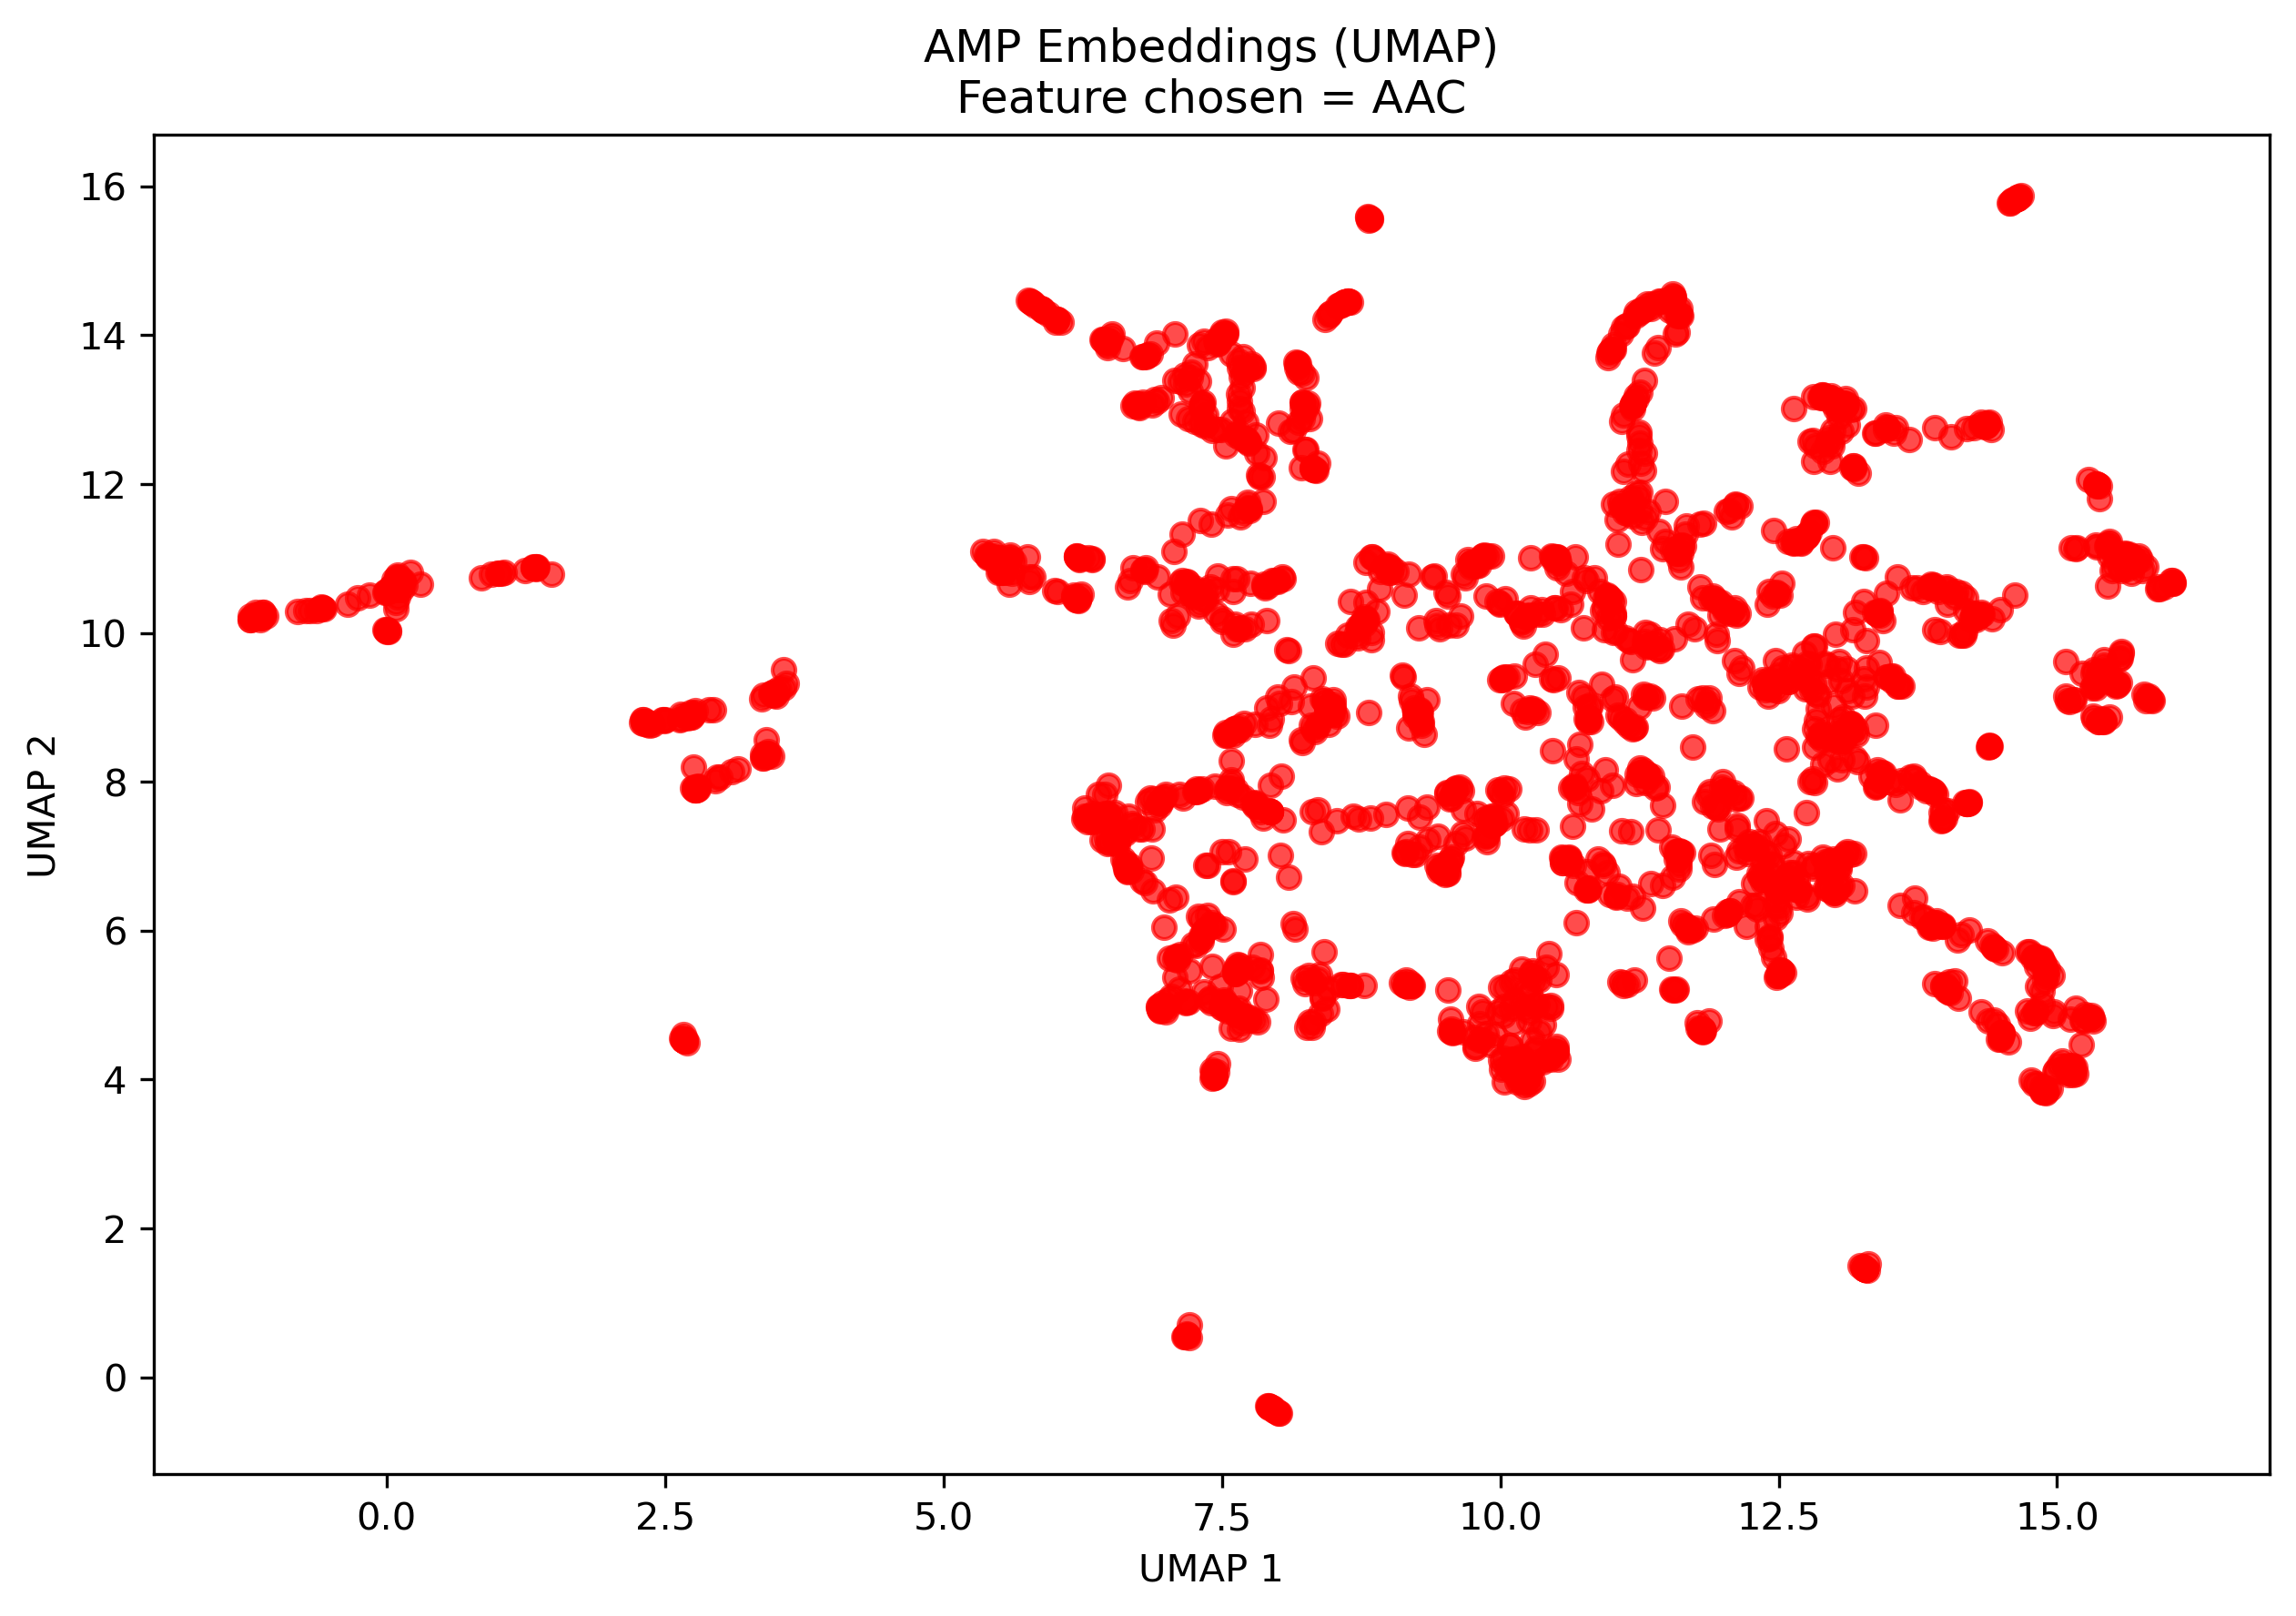

In [36]:
plt.figure(figsize=(10, 6.5), dpi=300)
plt.scatter(aa[:, 0], aa[:, 1], c='red', alpha=0.7)
# plt.scatter(bb[:, 0], bb[:, 1], c='chocolate', alpha=0.7)
# plt.scatter(cc[:, 0], cc[:, 1], c='yellowgreen', alpha=0.7)
# plt.scatter(dd[:, 0], dd[:, 1], c='turquoise', alpha=0.7)
plt.scatter(ee[:, 0], ee[:, 1], c='green', alpha=0.7)
# plt.scatter(ff[:, 0], ff[:, 1], c='blue', alpha=0.7)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title(f"AMP Embeddings (UMAP)\nFeature chosen = {' '.join(feature_list)}")
plt.show()